# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### Constants

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

daily_summary_days = 7 * 3
daily_plot_days = 7 * 2
tek_dumps_load_limit = daily_summary_days + 1

### COVID-19 Cases

In [4]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {spain_region_country_name}

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
confirmed_df = confirmed_df[pd.isna(confirmed_df.Region)]
confirmed_df.head()

,Country_EN,Country_ES,Country_IT,Region,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27
218,Spain,España,Spagna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,640040.0,640040.0,640040.0,671468.0,682267.0,693556.0,704209.0,716481.0,716481.0,716481.0


In [5]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27
218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,640040.0,640040.0,640040.0,671468.0,682267.0,693556.0,704209.0,716481.0,716481.0,716481.0


In [6]:
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-09-23,693556.0
2020-09-24,704209.0
2020-09-25,716481.0
2020-09-26,716481.0
2020-09-27,716481.0


In [7]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
244,2020-09-23,693556.0,11289.0,11314.0
245,2020-09-24,704209.0,10653.0,11223.0
246,2020-09-25,716481.0,12272.0,10920.0
247,2020-09-26,716481.0,0.0,10920.0
248,2020-09-27,716481.0,0.0,10920.0


In [8]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.covid_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)

confirmed_df["covid_cases"] = confirmed_df.covid_cases.fillna(0).astype(int)
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
245,2020-09-24,704209.0,10653.0,11223
246,2020-09-25,716481.0,12272.0,10920
247,2020-09-26,716481.0,0.0,10920
248,2020-09-27,716481.0,0.0,10920
248,2020-09-28,727401.0,10920.0,10920


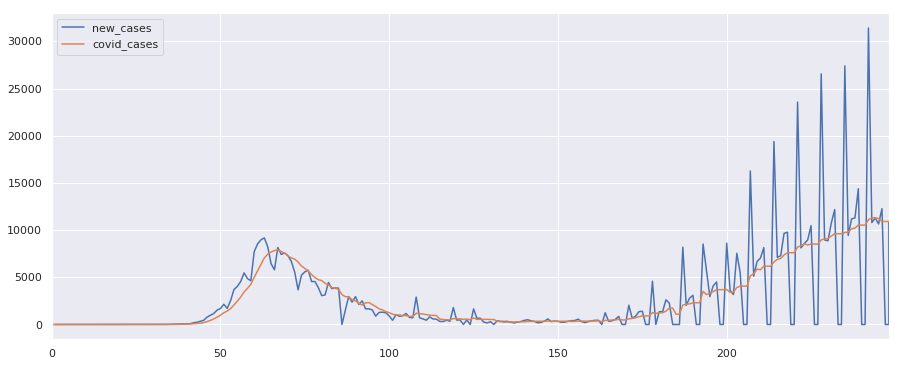

In [9]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [10]:
from Modules.RadarCOVID import radar_covid

raw_zip_paths = [
    "Data/TEKs/Raw/Current/RadarCOVID-TEKs-{sample_date}.zip",
    f"Data/TEKs/Raw/Daily/{extraction_date}/RadarCOVID-TEKs-{{sample_date}}.zip",
    f"Data/TEKs/Raw/Hourly/{extraction_date_with_hour}/RadarCOVID-TEKs-{{sample_date}}.zip",
]

multi_region_exposure_keys_df = \
    radar_covid.download_last_radar_covid_exposure_keys(
        days=14, save_raw_zip_path=raw_zip_paths)
multi_region_exposure_keys_df.head()

,sample_datetime,sample_date_string,source_url,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level
0,2020-09-28 00:00:00+00:00,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,002bb611-0b3a-1167-f5db-3224d274fd6a,2668752,96,0
1,2020-09-28 00:00:00+00:00,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,eafb211b-1a3e-35bd-79a9-3f15f9715ba5,2668752,93,0
2,2020-09-28 00:00:00+00:00,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,f450ce37-47ab-e071-d283-b14f37788b63,2668752,88,0
3,2020-09-28 00:00:00+00:00,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,89dceab6-4e03-13c5-37ad-332edc9e99bf,2668752,87,0
4,2020-09-28 00:00:00+00:00,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,V1,214,1.2.840.10045.4.3.2,427e5bcf-1ff9-6d80-bd22-97218e23dc09,2668752,87,0


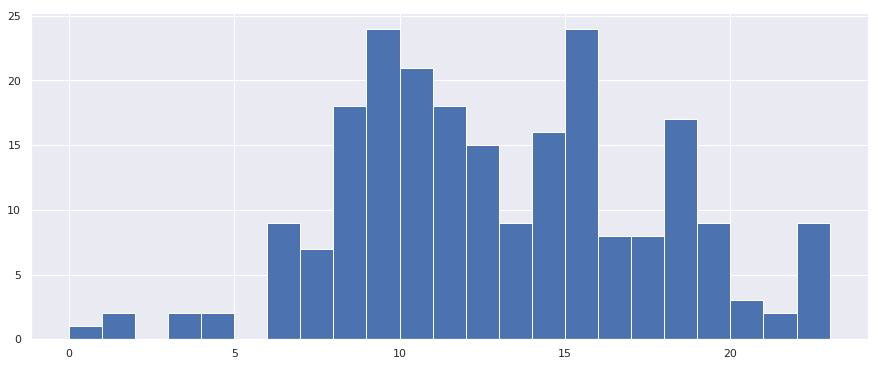

In [11]:
early_teks_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.rolling_period < radar_covid.maximum_key_rolling_period].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

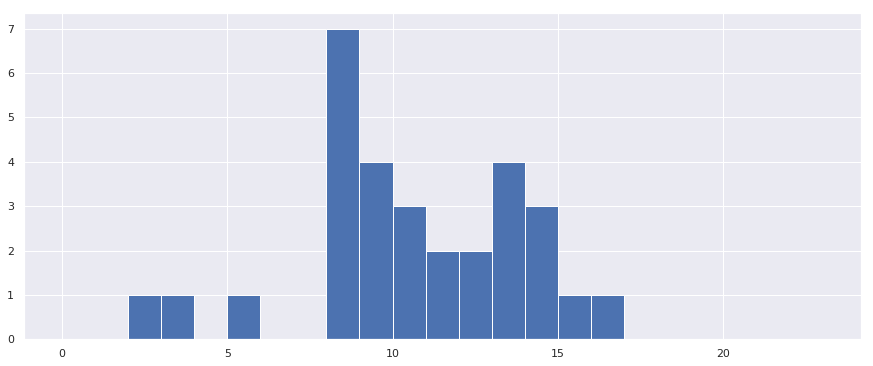

In [12]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [13]:
multi_region_exposure_keys_df = multi_region_exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]]
multi_region_exposure_keys_df.head()

,sample_date_string,source_url,region,key_data
0,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,002bb611-0b3a-1167-f5db-3224d274fd6a
1,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,eafb211b-1a3e-35bd-79a9-3f15f9715ba5
2,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,f450ce37-47ab-e071-d283-b14f37788b63
3,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,89dceab6-4e03-13c5-37ad-332edc9e99bf
4,2020-09-28,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,427e5bcf-1ff9-6d80-bd22-97218e23dc09


In [14]:
active_regions = \
    multi_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['ES']

In [15]:
multi_region_summary_df = multi_region_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
multi_region_summary_df.head()

,shared_teks_by_generation_date
region,ES
sample_date_string,
2020-09-28,30
2020-09-27,144
2020-09-26,208
2020-09-25,213
2020-09-24,251


In [16]:
multi_region_without_spain_exposure_keys_df = \
    multi_region_exposure_keys_df[multi_region_exposure_keys_df.region != spain_region_country_code]
active_regions_excluding_spain = \
    multi_region_without_spain_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions_excluding_spain

[]

In [17]:
exposure_keys_summary_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.region == spain_region_country_code]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-09-28,30
2020-09-27,144
2020-09-26,208
2020-09-25,213
2020-09-24,251


### Dump API TEKs

In [18]:
tek_list_df = multi_region_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    "Data/TEKs/Current/RadarCOVID-TEKs.json",
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-09-15,ES,"[31634101-bb0f-603e-79f1-818dc71bf69b, 09dda36...",2020-09-28,2020-09-28@17
1,2020-09-16,ES,"[9c7d05f3-84cd-66fc-3f89-92d7ba290aa5, dd79f09...",2020-09-28,2020-09-28@17
2,2020-09-17,ES,"[602daca2-f5d4-4231-3c20-92fda1d0643f, 3fbdaf2...",2020-09-28,2020-09-28@17
3,2020-09-18,ES,"[a550688a-6333-6c44-2d85-7ebad4d0e82c, cb3c439...",2020-09-28,2020-09-28@17
4,2020-09-19,ES,"[c0c836f6-7cea-d90c-3bf5-120ccaa8a819, 2400049...",2020-09-28,2020-09-28@17


### Load TEK Dumps

In [19]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    paths = list(reversed(sorted(glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [20]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=spain_region_country_code,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
0,ES,2020-09-15,"[31634101-bb0f-603e-79f1-818dc71bf69b, 09dda36...",2020-09-28
1,ES,2020-09-16,"[9c7d05f3-84cd-66fc-3f89-92d7ba290aa5, dd79f09...",2020-09-28
2,ES,2020-09-17,"[602daca2-f5d4-4231-3c20-92fda1d0643f, 3fbdaf2...",2020-09-28
3,ES,2020-09-18,"[a550688a-6333-6c44-2d85-7ebad4d0e82c, cb3c439...",2020-09-28
4,ES,2020-09-19,"[c0c836f6-7cea-d90c-3bf5-120ccaa8a819, 2400049...",2020-09-28


In [21]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-09-28,30
2020-09-27,144
2020-09-26,208
2020-09-25,213
2020-09-24,251


### Daily New TEKs

In [22]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-07,"{5dec7838-65e2-eaa8-8e17-06b56cacc9ef, 11624ca..."
2020-09-08,"{0de2524c-2595-c48d-13ca-fb1c8d5ece54, 5dec783..."
2020-09-09,"{89facbdf-34c1-6df5-667a-0c9a218d08a7, 0de2524..."
2020-09-10,"{89facbdf-34c1-6df5-667a-0c9a218d08a7, 0de2524..."
2020-09-11,"{89facbdf-34c1-6df5-667a-0c9a218d08a7, 0de2524..."


In [23]:
today_new_teks_set_df = tek_list_df.diff()
try:
    today_new_teks_set = today_new_teks_set_df[
        today_new_teks_set_df.index == extraction_date].tek_list.item()
except ValueError:
    today_new_teks_set = set()
today_new_teks_df = daily_extracted_teks_df[
    daily_extracted_teks_df.extraction_date == extraction_date].copy()
today_new_teks_df["today_teks"] = \
    today_new_teks_df.tek_list.apply(lambda x: set(x).intersection(today_new_teks_set))
today_new_teks_df["today_teks_by_generation_date"] = \
    today_new_teks_df.today_teks.apply(len)
today_new_teks_df = today_new_teks_df[["sample_date", "today_teks_by_generation_date"]]
today_new_teks_df.set_index("sample_date", inplace=True)
today_new_teks_df.tail()

<ipython-input-23-4d18d86f3c3b>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  today_new_teks_set = today_new_teks_set_df[


,today_teks_by_generation_date
sample_date,
2020-09-24,21
2020-09-25,21
2020-09-26,21
2020-09-27,46
2020-09-28,30


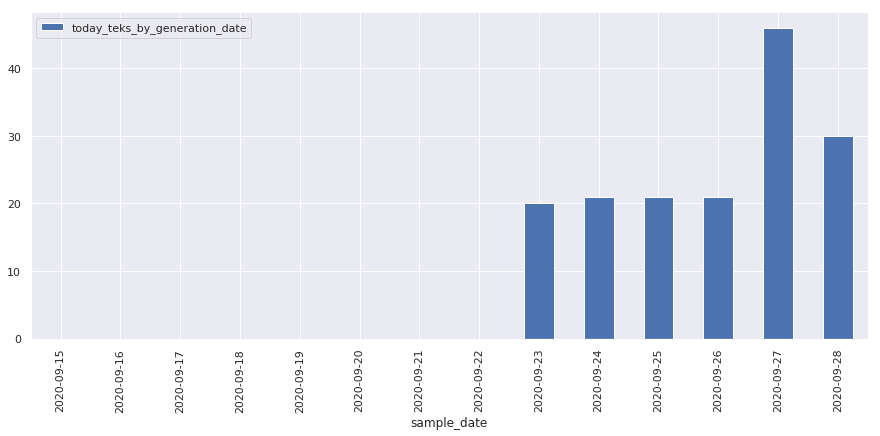

In [24]:
today_new_teks_df.plot.bar()

In [25]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
17,2020-09-24,289.0
18,2020-09-25,306.0
19,2020-09-26,448.0
20,2020-09-27,449.0
21,2020-09-28,159.0


In [26]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
0,ES,2020-09-15,"[31634101-bb0f-603e-79f1-818dc71bf69b, 09dda36...",2020-09-28,2020-09-16
1,ES,2020-09-16,"[9c7d05f3-84cd-66fc-3f89-92d7ba290aa5, dd79f09...",2020-09-28,2020-09-17
2,ES,2020-09-17,"[602daca2-f5d4-4231-3c20-92fda1d0643f, 3fbdaf2...",2020-09-28,2020-09-18
3,ES,2020-09-18,"[a550688a-6333-6c44-2d85-7ebad4d0e82c, cb3c439...",2020-09-28,2020-09-19
4,ES,2020-09-19,"[c0c836f6-7cea-d90c-3bf5-120ccaa8a819, 2400049...",2020-09-28,2020-09-20


In [27]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
13,2020-09-28,"[002bb611-0b3a-1167-f5db-3224d274fd6a, eafb211..."
13,2020-09-27,"[8f2bef11-a8eb-b2e5-2491-5e07d7250262, 0472ca9..."
13,2020-09-26,"[a69399a5-1b23-be87-cc66-601a1b76fd89, 0306447..."
13,2020-09-25,"[a5a10ba0-d9d8-c3fd-1dd2-211cefe2daf1, f38ed0c..."
13,2020-09-24,"[e50b39c0-7a14-64e4-56ca-a1e42190eec8, 4937ac0..."


In [28]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
13,2020-09-28,30
13,2020-09-27,98
13,2020-09-26,79
13,2020-09-25,14
13,2020-09-24,17


In [29]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date
12,ES,2020-09-27,"[00c96152-01df-b4b4-c019-6c731b882541, 6efc12b...",2020-09-28,2020-09-28
12,ES,2020-09-26,"[039f3e27-96b2-3b6a-748d-5070c8291369, e97c941...",2020-09-27,2020-09-27
12,ES,2020-09-25,"[80459115-080b-847c-2c3a-ffdf016379ec, df35cae...",2020-09-26,2020-09-26
12,ES,2020-09-24,"[47e258af-36cd-117b-482d-84655184ffd6, 62c0e0e...",2020-09-25,2020-09-25
12,ES,2020-09-23,"[a32a59f9-242d-082f-5499-d59cc496b461, 253d5ce...",2020-09-24,2020-09-24


In [30]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,new_sample_extraction_date,same_day_tek_list
0,ES,2020-09-27,"[00c96152-01df-b4b4-c019-6c731b882541, 6efc12b...",2020-09-28,2020-09-28,"[8f2bef11-a8eb-b2e5-2491-5e07d7250262, 0472ca9..."
1,ES,2020-09-26,"[039f3e27-96b2-3b6a-748d-5070c8291369, e97c941...",2020-09-27,2020-09-27,"[a69399a5-1b23-be87-cc66-601a1b76fd89, 0306447..."
2,ES,2020-09-25,"[80459115-080b-847c-2c3a-ffdf016379ec, df35cae...",2020-09-26,2020-09-26,"[a5a10ba0-d9d8-c3fd-1dd2-211cefe2daf1, f38ed0c..."
3,ES,2020-09-24,"[47e258af-36cd-117b-482d-84655184ffd6, 62c0e0e...",2020-09-25,2020-09-25,"[e50b39c0-7a14-64e4-56ca-a1e42190eec8, 4937ac0..."
4,ES,2020-09-23,"[a32a59f9-242d-082f-5499-d59cc496b461, 253d5ce...",2020-09-24,2020-09-24,"[6593604c-ae79-fade-9448-9781bbec6553, d527a06..."


In [31]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
estimated_shared_diagnoses_df["sample_date_string"] = estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-09-28,46
1,2020-09-27,108
2,2020-09-26,110
3,2020-09-25,86
4,2020-09-24,89


### Hourly New TEKs

In [32]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=spain_region_country_code, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,ES,2020-09-15,"[31634101-bb0f-603e-79f1-818dc71bf69b, 09dda36...",2020-09-28,2020-09-28@17
1,ES,2020-09-16,"[9c7d05f3-84cd-66fc-3f89-92d7ba290aa5, dd79f09...",2020-09-28,2020-09-28@17
2,ES,2020-09-17,"[602daca2-f5d4-4231-3c20-92fda1d0643f, 3fbdaf2...",2020-09-28,2020-09-28@17
3,ES,2020-09-18,"[a550688a-6333-6c44-2d85-7ebad4d0e82c, cb3c439...",2020-09-28,2020-09-28@17
4,ES,2020-09-19,"[c0c836f6-7cea-d90c-3bf5-120ccaa8a819, 2400049...",2020-09-28,2020-09-28@17


In [33]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-09-27@17,0
1,2020-09-27@18,22
2,2020-09-27@19,0
3,2020-09-27@20,50
4,2020-09-27@21,0


In [34]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-09-27@17,0
1,2020-09-27@18,3
2,2020-09-27@19,0
3,2020-09-27@20,8
4,2020-09-27@21,0


In [35]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-09-27 18:00:00,2020-09-27@18,22,3
2020-09-27 19:00:00,2020-09-27@19,0,0
2020-09-27 20:00:00,2020-09-27@20,50,8
2020-09-27 21:00:00,2020-09-27@21,0,0
2020-09-27 22:00:00,2020-09-27@22,15,2


### Data Merge

In [36]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-09-28,30,159.0
1,2020-09-27,144,449.0
2,2020-09-26,208,448.0
3,2020-09-25,213,306.0
4,2020-09-24,251,289.0


In [37]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-09-28,30,159.0,30.0
1,2020-09-27,144,449.0,98.0
2,2020-09-26,208,448.0,79.0
3,2020-09-25,213,306.0,14.0
4,2020-09-24,251,289.0,17.0


In [38]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-09-28,30,159.0,30.0,46.0
1,2020-09-27,144,449.0,98.0,108.0
2,2020-09-26,208,448.0,79.0,110.0
3,2020-09-25,213,306.0,14.0,86.0
4,2020-09-24,251,289.0,17.0,89.0


In [39]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-09-08,534513.0,8964.0,9077,61,44.0,NaN,18.0
1,2020-09-09,543379.0,8866.0,9118,60,67.0,NaN,21.0
2,2020-09-10,554143.0,10764.0,9376,68,45.0,NaN,15.0
3,2020-09-11,566326.0,12183.0,9620,75,46.0,NaN,19.0
4,2020-09-12,566326.0,0.0,9620,67,92.0,NaN,33.0


In [40]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,,
2020-09-28,727401.0,10920.0,10920,30,159.0,30.0,46.0
2020-09-27,716481.0,0.0,10920,144,449.0,98.0,108.0
2020-09-26,716481.0,0.0,10920,208,448.0,79.0,110.0
2020-09-25,716481.0,12272.0,10920,213,306.0,14.0,86.0
2020-09-24,704209.0,10653.0,11223,251,289.0,17.0,89.0


In [41]:
result_summary_df = result_summary_df.fillna(0).astype(int)
result_summary_df["teks_per_shared_diagnosis"] = \
    result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses
result_summary_df["shared_diagnoses_per_covid_case"] = \
    result_summary_df.shared_diagnoses / result_summary_df.covid_cases
result_summary_df.head(daily_plot_days)

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,,
2020-09-28,727401,10920,10920,30,159,30,46,3.456522,0.004212
2020-09-27,716481,0,10920,144,449,98,108,4.157407,0.009890
2020-09-26,716481,0,10920,208,448,79,110,4.072727,0.010073
2020-09-25,716481,12272,10920,213,306,14,86,3.558140,0.007875
2020-09-24,704209,10653,11223,251,289,17,89,3.247191,0.007930
2020-09-23,693556,11289,11314,290,267,4,70,3.814286,0.006187
2020-09-22,682267,10799,11300,282,148,0,55,2.690909,0.004867
2020-09-21,671468,31428,11105,268,190,0,45,4.222222,0.004052
2020-09-20,640040,0,10531,218,116,0,45,2.577778,0.004273


In [42]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)
weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
weekly_result_summary_df["teks_per_shared_diagnosis"] = \
    weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses
weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
    weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases
weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-09-28,77517,1418,2066,564,3.663121,0.007276
2020-09-27,77702,1656,2097,563,3.724689,0.007246
2020-09-26,77313,1730,1764,500,3.528000,0.006467
2020-09-25,76924,1725,1406,429,3.277389,0.005577
2020-09-24,76535,1677,1238,395,3.134177,0.005161


In [43]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[0]
last_7_days_summary

{'covid_cases': 77517,
 'shared_teks_by_generation_date': 1418,
 'shared_teks_by_upload_date': 2066,
 'shared_diagnoses': 564,
 'teks_per_shared_diagnosis': 3.6631205673758864,
 'shared_diagnoses_per_covid_case': 0.007275823367777391}

## Report Results

In [44]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date",
    "datetime_utc": "Timestamp (UTC)",
    "covid_cases": "COVID-19 Cases (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [45]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [46]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases Which Shared Diagnosis)
Sample Date,,,,,,,
2020-09-28,10920,30,159,30,46,3.456522,0.004212
2020-09-27,10920,144,449,98,108,4.157407,0.009890
2020-09-26,10920,208,448,79,110,4.072727,0.010073
2020-09-25,10920,213,306,14,86,3.558140,0.007875
2020-09-24,11223,251,289,17,89,3.247191,0.007930
2020-09-23,11314,290,267,4,70,3.814286,0.006187
2020-09-22,11300,282,148,0,55,2.690909,0.004867
2020-09-21,11105,268,190,0,45,4.222222,0.004052
2020-09-20,10531,218,116,0,45,2.577778,0.004273


### Daily Summary Plots

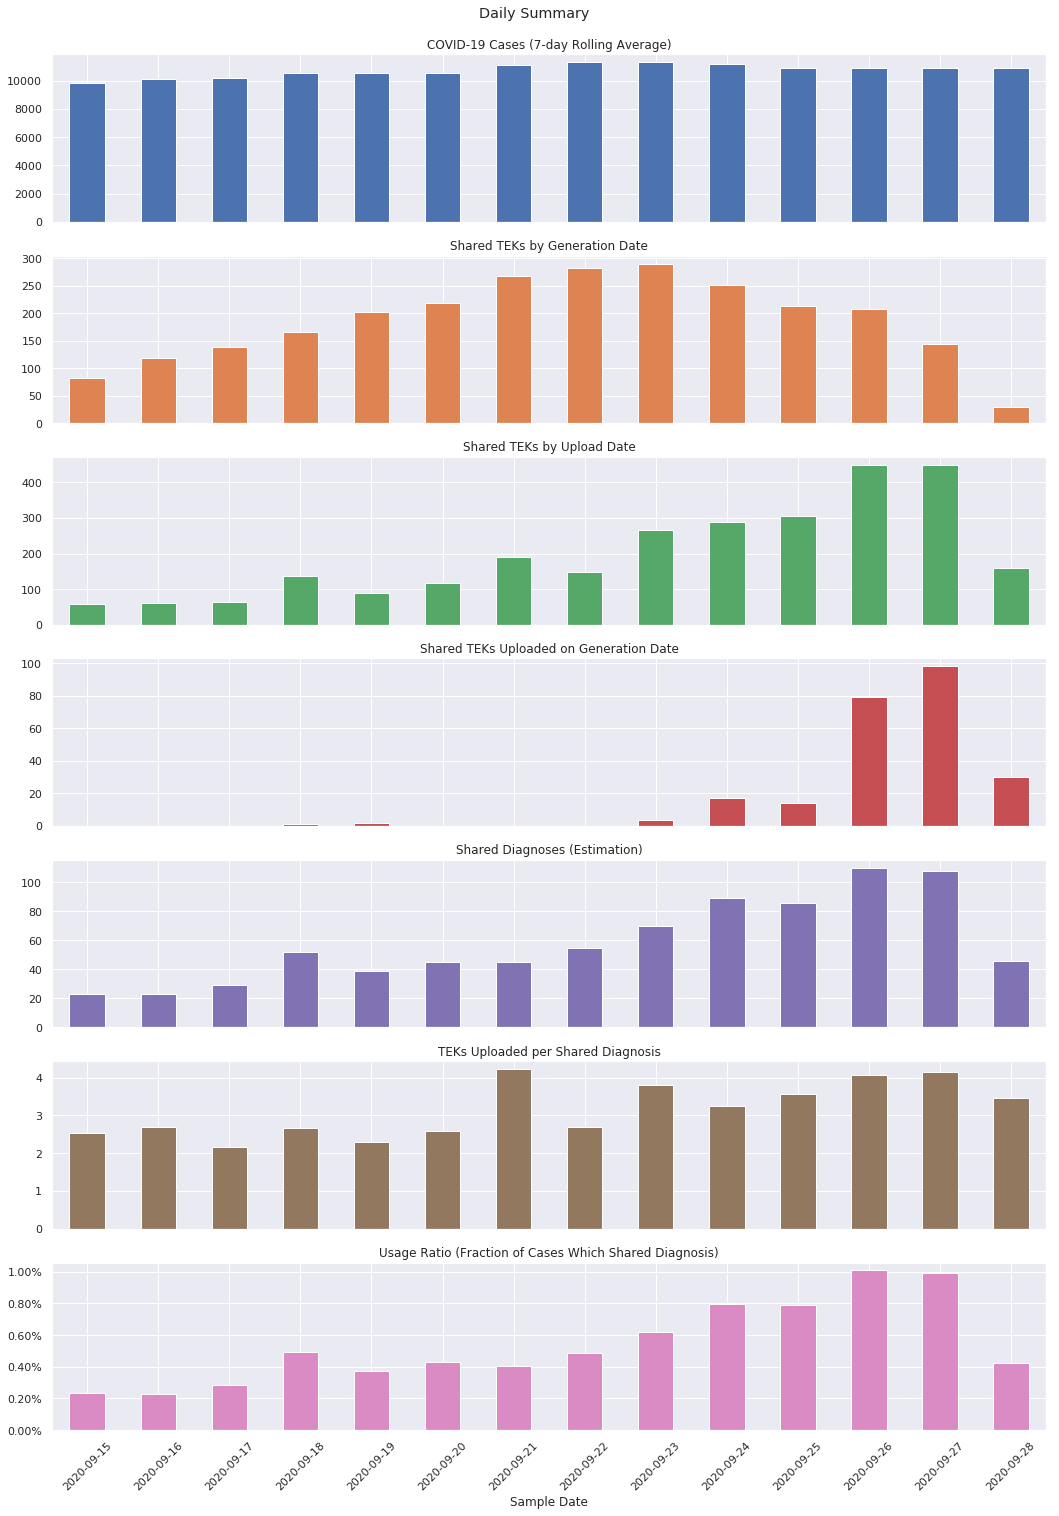

In [47]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Hourly Summary Plots 

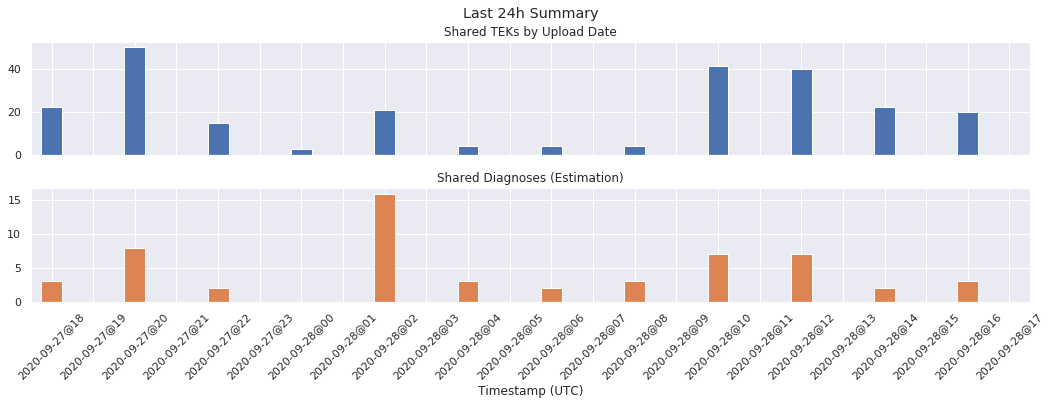

In [48]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [49]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [50]:
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(
        formatters={
            display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
            display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
        })

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

In [51]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_region_summary_df)

### Save Results

In [52]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_region_summary_df.to_csv(report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(multi_region_summary_table_image_path, report_resources_path_prefix + "Multi-Region-Summary-Table.png")

report_daily_url_pattern = \
    "https://github.com/pvieito/RadarCOVID-STATS/blob/master/Notebooks/" \
    "RadarCOVID-Report/{report_type}/RadarCOVID-Report-{report_date}.ipynb"
report_daily_url = report_daily_url_pattern.format(
    report_type="Daily", report_date=extraction_date)
report_hourly_url = report_daily_url_pattern.format(
    report_type="Hourly", report_date=extraction_date_with_hour)

### Publish Results as JSON

In [53]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [54]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    daily_summary_table_html=daily_summary_table_html,
    report_url_with_hour=report_hourly_url,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [55]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    status = textwrap.dedent(f"""
        #RadarCOVID Report – {extraction_date_with_hour}

        Today:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - TEKs per Diagnosis: ≥{teks_per_shared_diagnosis:.2}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Week:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        More Info: https://github.com/pvieito/RadarCOVID-STATS#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)